## Goal: risk assessment for first time loan to buy smartphone

The model should either approve/reject users based on risk

This notebook contains the following sections/steps:
1. The loading, preprocessing and data cleaning of the **credit reports** data frame.
2. The loading, preprocessing and data cleaning of the **main** data frame.
3. The merging of the credit reports data frame and the main data frame, as well as feature engineering and handling of null data.
4. The creation and running of the ML model for approval/rejection of loan applications based on risk assessment.
5. Suggestions and proposals and how to best implement said model, as well as combine it with other potential models.

Any questions should be directed to **Alejandra Budar**

## 1. Credit reports data frame

In [1]:
# Note: some columns are confusing, like max_credit vs credit_limit

import pandas as pd

credit_reports = pd.read_parquet('credit_reports.parquet')

credit_reports.head()

,customer_id,INQUIRY_TIME,CDC_INQUIRY_ID,INQUIRY_DATE,PREVENTION_KEY,CURRENCY,MAX_CREDIT,CREDIT_LIMIT,PAYMENT_AMOUNT,UPDATE_DATE,...,ACCOUNT_TYPE,RESPONSABILITY_TYPE,TOTAL_PAYMENTS,DELAYED_PAYMENTS,CURRENT_PAYMENT,WORST_DELAY,TOTAL_REPORTED_PAYMENTS,CURRENT_BALANCE,BALANCE_DUE,BALANCE_DUE_WORST_DELAY
0,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01,SIN OBSERVACION,PESOS MEXICANOS,1244.0,9900.0,1244.0,2022-02-28,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),12.0,7,13,13.0,0,1244.0,1244.0,1244.0
1,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01,SIN OBSERVACION,PESOS MEXICANOS,1722.0,9900.0,1722.0,2022-02-28,...,REVOLVENTE,INDIVIDUAL (TITULAR),0.0,3,13,13.0,0,1722.0,1722.0,1722.0
2,4223,2022-04-01 00:32:36.689000+00:00,710278-27993a6e-2885-48d4-a753-9249e7022af1,2022-04-01,SIN OBSERVACION,PESOS MEXICANOS,6346.0,0.0,482.0,2022-03-28,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),16.0,0,V,0.0,0,943.0,0.0,0.0
3,3490,2022-02-15 02:30:22.086000+00:00,622857-6b4e9d95-7491-40c3-bccd-442de7f94c58,2022-02-15,SIN OBSERVACION,PESOS MEXICANOS,11600.0,0.0,232.0,2022-02-01,...,PAGOS FIJOS,INDIVIDUAL (TITULAR),100.0,4,01,1.0,0,6185.0,116.0,116.0
4,6486,2022-06-25 01:57:14.868000+00:00,875073-46a5f149-19db-4193-b92a-b8f41fb3e896,2022-06-25,SIN OBSERVACION,PESOS MEXICANOS,2452.0,16800.0,2452.0,2021-09-30,...,REVOLVENTE,INDIVIDUAL (TITULAR),0.0,19,13,13.0,0,2452.0,2452.0,2452.0


In [2]:
credit_reports['INQUIRY_DATE'].max()

Timestamp('2023-05-17 00:00:00')

In [3]:
credit_reports['INQUIRY_DATE'].min()

Timestamp('2021-04-29 00:00:00')

In [4]:
print(credit_reports.iloc[0])

customer_id                                                       4223
INQUIRY_TIME                          2022-04-01 00:32:36.689000+00:00
CDC_INQUIRY_ID             710278-27993a6e-2885-48d4-a753-9249e7022af1
INQUIRY_DATE                                       2022-04-01 00:00:00
PREVENTION_KEY                                         SIN OBSERVACION
CURRENCY                                               PESOS MEXICANOS
MAX_CREDIT                                                      1244.0
CREDIT_LIMIT                                                    9900.0
PAYMENT_AMOUNT                                                  1244.0
UPDATE_DATE                                        2022-02-28 00:00:00
LOAN_OPENING_DATE                                  2019-08-30 00:00:00
LOAN_CLOSING_DATE                                                  NaT
WORST_DELAY_DATE                                   2022-01-31 00:00:00
REPORT_DATE                                        2022-02-28 00:00:00
LAST_P

In [5]:
credit_reports.columns

Index(['customer_id', 'INQUIRY_TIME', 'CDC_INQUIRY_ID', 'INQUIRY_DATE',
       'PREVENTION_KEY', 'CURRENCY', 'MAX_CREDIT', 'CREDIT_LIMIT',
       'PAYMENT_AMOUNT', 'UPDATE_DATE', 'LOAN_OPENING_DATE',
       'LOAN_CLOSING_DATE', 'WORST_DELAY_DATE', 'REPORT_DATE',
       'LAST_PURCHASE_DATE', 'LAST_PAYMENT_DATE', 'PAYMENT_FREQUENCY',
       'BUSINESS_TYPE', 'CREDIT_TYPE', 'ACCOUNT_TYPE', 'RESPONSABILITY_TYPE',
       'TOTAL_PAYMENTS', 'DELAYED_PAYMENTS', 'CURRENT_PAYMENT', 'WORST_DELAY',
       'TOTAL_REPORTED_PAYMENTS', 'CURRENT_BALANCE', 'BALANCE_DUE',
       'BALANCE_DUE_WORST_DELAY'],
      dtype='object')

In [6]:
credit_reports['customer_id'] = credit_reports['customer_id'].astype(object)

In [7]:
# This logic assumes that a null in the 'LOAN_CLOSING_DATE' column means that the loan is currently active and has yet to be repaid
# Creates a new column withe the count of how many active loans the member has (up until the time the data was pulled)

credit_reports['ACTIVE_LOANS_COUNT'] = credit_reports.groupby('customer_id')['LOAN_CLOSING_DATE'].transform(lambda x: x.isnull().sum())


In [8]:
# Removing columns that 1) are likely not useful 2) may have colineraity with another column 3) reducing dimensionality to minimize overfitting
credit_reports_filtered = credit_reports[['customer_id', 'CREDIT_LIMIT',
       'PAYMENT_AMOUNT', 'ACTIVE_LOANS_COUNT', 'PAYMENT_FREQUENCY',
       'CREDIT_TYPE', 'RESPONSABILITY_TYPE',
       'TOTAL_PAYMENTS', 'DELAYED_PAYMENTS', 'BALANCE_DUE', 'CURRENT_BALANCE', 'MAX_CREDIT']]

In [9]:
credit_reports_filtered['RESPONSABILITY_TYPE'].unique()

array(['INDIVIDUAL (TITULAR)', 'TITULAR CON AVAL',
       'OBLIGATORIO SOLIDARIO', None, 'MANCOMUNADO', 'AVAL'], dtype=object)

In [10]:
credit_reports_filtered.shape

(287356, 12)

In [11]:
credit_reports_filtered.dtypes

customer_id             object
CREDIT_LIMIT           float64
PAYMENT_AMOUNT         float64
ACTIVE_LOANS_COUNT       int64
PAYMENT_FREQUENCY       object
CREDIT_TYPE             object
RESPONSABILITY_TYPE     object
TOTAL_PAYMENTS         float64
DELAYED_PAYMENTS        object
BALANCE_DUE            float64
CURRENT_BALANCE        float64
MAX_CREDIT             float64
dtype: object

In [12]:
# Changing dtype from object to float64 to match other columns

credit_reports_filtered['DELAYED_PAYMENTS'] = credit_reports_filtered['DELAYED_PAYMENTS'].astype(float)


<ipython-input-12-c3fa73dc40f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_reports_filtered['DELAYED_PAYMENTS'] = credit_reports_filtered['DELAYED_PAYMENTS'].astype(float)


In [13]:
credit_reports_filtered.isnull().sum()

customer_id                0
CREDIT_LIMIT            8357
PAYMENT_AMOUNT            89
ACTIVE_LOANS_COUNT         0
PAYMENT_FREQUENCY         89
CREDIT_TYPE               89
RESPONSABILITY_TYPE       89
TOTAL_PAYMENTS         18645
DELAYED_PAYMENTS          89
BALANCE_DUE               89
CURRENT_BALANCE           89
MAX_CREDIT               182
dtype: int64

##2. Main dataset data frame

In [16]:
import pandas as pd

main_data = pd.read_parquet('main_dataset.parquet')

main_data.head()

,customer_id,loan_id,ACC_CREATION_DATETIME,APPLICATION_DATETIME,LOAN_ORIGINATION_DATETIME,max_days_late,target,account_to_application_days,n_sf_apps,first_app_date,last_app_date,n_bnpl_apps,n_bnpl_approved_apps,first_bnpl_app_date,last_bnpl_app_date,n_inquiries_l3m,n_inquiries_l6m
0,1223,1,2021-08-23 13:57:56,2022-04-26 07:00:00,2022-10-20 18:26:35,5,0,245,1.0,2022-04-25,2022-04-25,1.0,0.0,2022-04-26 02:15:17.742,2022-04-26 02:15:17.742,91.0,91.0
1,5190,2,2022-04-26 09:57:25,2022-04-26 07:00:00,2022-12-22 18:03:32,2,0,0,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaN
2,5194,3,2022-04-26 12:22:35,2022-04-26 07:00:00,2022-08-09 17:31:05,4,0,0,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaN
3,3978,4,2022-03-09 11:26:55,2022-04-26 07:00:00,2022-11-11 19:48:08,2,0,47,1.0,2022-03-17,2022-03-17,2.0,0.0,2022-03-19 22:02:50.555,2022-03-09 16:41:49.675,13.0,13.0
4,4535,5,2022-04-01 14:28:42,2022-04-26 07:00:00,2022-07-24 12:07:15,2,0,24,1.0,2022-04-01,2022-04-01,1.0,0.0,2022-04-01 19:37:56.185,2022-04-01 19:37:56.185,21.0,21.0


In [17]:
main_data.columns

Index(['customer_id', 'loan_id', 'ACC_CREATION_DATETIME',
       'APPLICATION_DATETIME', 'LOAN_ORIGINATION_DATETIME', 'max_days_late',
       'target', 'account_to_application_days', 'n_sf_apps', 'first_app_date',
       'last_app_date', 'n_bnpl_apps', 'n_bnpl_approved_apps',
       'first_bnpl_app_date', 'last_bnpl_app_date', 'n_inquiries_l3m',
       'n_inquiries_l6m'],
      dtype='object')

In [18]:
main_data['customer_id'] = main_data['customer_id'].astype(object)

<Axes: xlabel='target', ylabel='count'>

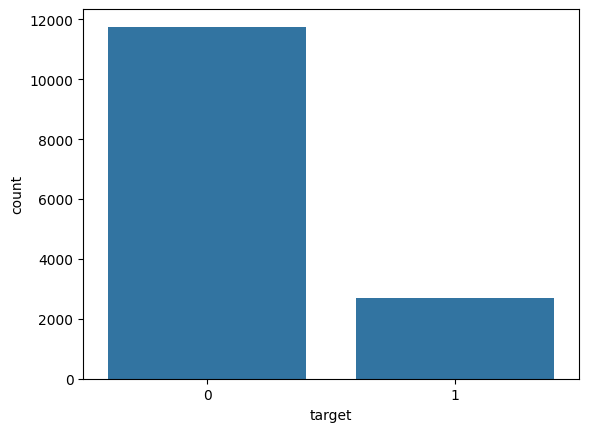

In [19]:
# Checking the balance of the target variable

import seaborn as sns

sns.countplot(main_data, x="target")

In [20]:
# Removing columns that will likely not be helpful for the model and may cause overfitting

main_data_filtered = main_data[['customer_id', 'max_days_late',
       'target', 'account_to_application_days',  'n_bnpl_apps', 'n_bnpl_approved_apps',
       'first_bnpl_app_date', 'last_bnpl_app_date',
       'n_inquiries_l6m']]

In [21]:
main_data_filtered.dtypes

customer_id                            object
max_days_late                           int64
target                                  int64
account_to_application_days             int64
n_bnpl_apps                           float64
n_bnpl_approved_apps                  float64
first_bnpl_app_date            datetime64[us]
last_bnpl_app_date             datetime64[us]
n_inquiries_l6m                       float64
dtype: object

In [24]:
# There seems to be a standardization issue (shouldn't they all be positive?)

main_data_filtered['max_days_late'].unique()

array([ 5,  2,  4,  7,  0,  8,  1, 55, 63,  3, 49, 70, -1,  6, 39, 42, 13,
       33, 28, 31, 12, 11, 35, 69, 21, 22, 16, 48, 10, 14, -4, 34, 17, 62,
       -3,  9, -2, 41, 25, 15, 56, 19, 27, 23, 18, 29, 20, 24, 32, 38, -7,
       52, 37, 60, 54, 30, 50, 46, -5, 43, 26, 53, 47, 51, 44, 40, 36, 45,
       66, 59, 67, 58, 57, -6, 64, 68, 61])

In [25]:
# Changing to absolute numbers of the values

main_data_filtered['max_days_late'] = main_data_filtered['max_days_late'].abs()

<ipython-input-25-fc4440fc1249>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_data_filtered['max_days_late'] = main_data_filtered['max_days_late'].abs()


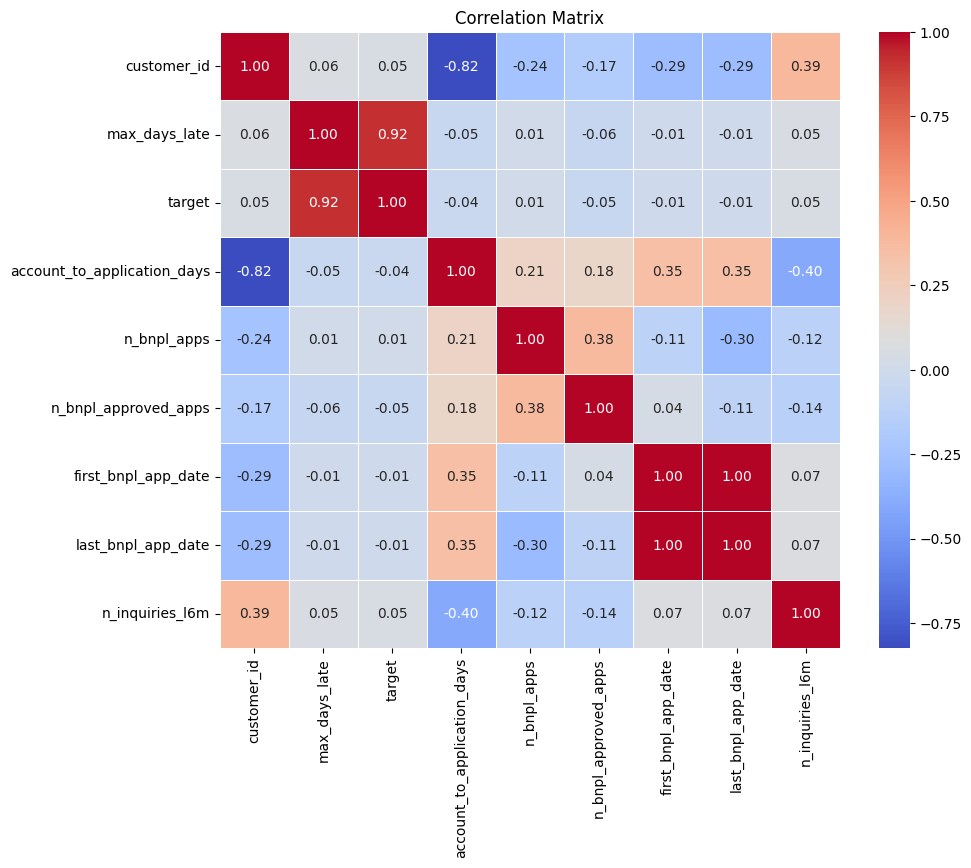

In [26]:
# Using a correlation matrix to identify multicolinearity and idenitfy which features are more high associated with target variable
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = main_data_filtered.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title and show plot
plt.title('Correlation Matrix')
plt.show()


In [27]:
# Removing first_bnpl_app_date and last_bnpl_app_date because they are too highly correlated with account_to_application_days

main_data_filtered = main_data_filtered[['customer_id', 'max_days_late',
       'target', 'account_to_application_days',  'n_bnpl_apps', 'n_bnpl_approved_apps',
       'n_inquiries_l6m']]

#3. Combining of data frames

In [28]:
# Merge datasets on 'customer_id'
merged_data = pd.merge(main_data_filtered, credit_reports_filtered , on='customer_id', how='inner')

In [29]:
merged_data.head()

,customer_id,max_days_late,target,account_to_application_days,n_bnpl_apps,n_bnpl_approved_apps,n_inquiries_l6m,CREDIT_LIMIT,PAYMENT_AMOUNT,ACTIVE_LOANS_COUNT,PAYMENT_FREQUENCY,CREDIT_TYPE,RESPONSABILITY_TYPE,TOTAL_PAYMENTS,DELAYED_PAYMENTS,BALANCE_DUE,CURRENT_BALANCE,MAX_CREDIT
0,1223,5,0,245,1.0,0.0,91.0,0.0,0.0,29,MENSUAL,LINEA DE CREDITO,INDIVIDUAL (TITULAR),NaN,0.0,0.0,0.0,3000.0
1,1223,5,0,245,1.0,0.0,91.0,2200.0,0.0,29,MENSUAL,PRESTAMO PERSONAL,INDIVIDUAL (TITULAR),1.0,0.0,0.0,0.0,500.0
2,1223,5,0,245,1.0,0.0,91.0,2200.0,0.0,29,MENSUAL,PRESTAMO PERSONAL,INDIVIDUAL (TITULAR),1.0,0.0,0.0,0.0,1100.0
3,1223,5,0,245,1.0,0.0,91.0,2500.0,0.0,29,MENSUAL,PRESTAMO PERSONAL,INDIVIDUAL (TITULAR),1.0,0.0,0.0,0.0,1700.0
4,1223,5,0,245,1.0,0.0,91.0,2500.0,0.0,29,MENSUAL,PRESTAMO PERSONAL,INDIVIDUAL (TITULAR),1.0,0.0,0.0,0.0,1800.0


# 4. Creating model



In [30]:
# Data engineering more columns
import numpy as np

# Calculating Approval Rate Ratio
merged_data['approval_rate'] = merged_data['n_bnpl_approved_apps'] / merged_data['n_bnpl_apps']

# Calculating Late Payment Ratio
merged_data['late_payment_ratio'] = merged_data['DELAYED_PAYMENTS'] / merged_data['TOTAL_PAYMENTS']
# Dealing with inf
merged_data['late_payment_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Calculating Payment-to-Balance Ratio
# Removed because 'CURRENT_PAYMENT' column doesn't appear to be what I thought it was
# merged_data['payment_to_balance_ratio'] = merged_data['CURRENT_PAYMENT'] / merged_data['CURRENT_BALANCE']

# Calculating Credit Utilization Ratio
merged_data['credit_utilization'] = merged_data['CURRENT_BALANCE'] / merged_data['MAX_CREDIT']
# Dealing with inf
merged_data['credit_utilization'].replace([np.inf, -np.inf], np.nan, inplace=True)

#Calculating days between first and last application
# Removed because if it's a person's first time applying, this will be 0 which may create a bias in the algorithm
# merged_data['days_btw_apps'] = (merged_data['first_bnpl_app_date'] - merged_data['last_bnpl_app_date']).dt.days


In [31]:
merged_data.isnull().sum()

customer_id                        0
max_days_late                      0
target                             0
account_to_application_days        0
n_bnpl_apps                    20212
n_bnpl_approved_apps           20212
n_inquiries_l6m                 1700
CREDIT_LIMIT                    8357
PAYMENT_AMOUNT                    89
ACTIVE_LOANS_COUNT                 0
PAYMENT_FREQUENCY                 89
CREDIT_TYPE                       89
RESPONSABILITY_TYPE               89
TOTAL_PAYMENTS                 18645
DELAYED_PAYMENTS                  89
BALANCE_DUE                       89
CURRENT_BALANCE                   89
MAX_CREDIT                       182
approval_rate                  20212
late_payment_ratio             53766
credit_utilization              8439
dtype: int64

In [32]:
# Dropping missing values, if accuracy is too low after this, will use KNN imputer instead

merged_data.dropna(inplace=True)

In [34]:
merged_data.duplicated().sum()

31449

In [35]:
# Dropping duplicates to reduce the chance of over-fitting

merged_data.drop_duplicates(inplace=True)

In [36]:
merged_data.shape

(177552, 21)

In [37]:
# Identifying features and target variable

X = merged_data[['max_days_late', 'account_to_application_days',
       'n_inquiries_l6m', 'CREDIT_LIMIT', 'ACTIVE_LOANS_COUNT',
       'approval_rate', 'late_payment_ratio',
       'credit_utilization','PAYMENT_FREQUENCY', 'CREDIT_TYPE','TOTAL_PAYMENTS', 'DELAYED_PAYMENTS', 'BALANCE_DUE', 'CURRENT_BALANCE',
       'MAX_CREDIT', 'RESPONSABILITY_TYPE',]]

y = merged_data[['target']]

In [38]:
import pandas as pd

# Get dummies
X_encoded = pd.get_dummies(X, dtype=int)


In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Oversample the minority class (which in this case is those with a target variable of 1)
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_encoded, y)

# Scale features to reduce variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Define number of folds
k = 2

# Initialize KFold
kf = KFold(n_splits=k)

# Lists to store evaluation results
accuracies = []
confusion_matrices = []
precision_list = []
recall_list = []
f1_score_list = []
support_list = []

# Iterate over folds
for train_index, test_index in kf.split(X_scaled):
    # Split data into training and testing sets
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    y_train = np.ravel(y_train)  # Reshape y_train to 1d array
    y_test = np.ravel(y_test)  # Reshape y_test to 1d array

    # Choose algorithm for binary classification
    model = RandomForestClassifier(n_estimators=3, random_state=42)

    # Train model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    confusion_matrix_arr = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(confusion_matrix_arr)

    # Generate classification report
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    precision_list.append(report_dict['macro avg']['precision'])
    recall_list.append(report_dict['macro avg']['recall'])
    f1_score_list.append(report_dict['macro avg']['f1-score'])
    support_list.append(report_dict['macro avg']['support'])

# Calculate average metrics over all folds
avg_accuracy = sum(accuracies) / k
avg_confusion_matrix = sum(confusion_matrices) / k

# Calculate average metrics over all folds
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1_score = np.mean(f1_score_list)
avg_support = np.mean(support_list)

# Print average evaluation metrics
print("Average Accuracy:", avg_accuracy)
print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-score:", avg_f1_score)
print("Average Support:", avg_support)
print("Average Confusion Matrix:")
print(avg_confusion_matrix)

Average Accuracy: 0.9976119504098638
Average Precision: 0.9932670372983912
Average Recall: 0.9985495117960204
Average F1-score: 0.9958602694916332
Average Support: 147610.0
Average Confusion Matrix:
[[73452.5   352.5]
 [    0.  73805. ]]


Even though I implemented a k-folds evaluation metric, there's still a slight possibility that the model is  overfitting. Given more time, I would use KNNImputer to address null values instead of simply discarding them. This would allow for the retention of more data, likely enhancing the model's performance and robustness.

# 5. Recommendations and Proposals for Interest Rate Assignment

Utilize the predictions from the primary model developed to determine loan approval decisions for customers. Integrate these predictions into a secondary model that incorporates additional data, including regulatory requirements, market conditions, and business considerations.


The secondary model should predict the probability of defaulting on a given loan.


Nest, assign probability thresholds to categorize members into different risk categories, such as low risk, medium risk, and high risk. Additional risk categories can be added based on specific business needs and risk tolerance.

Based on the assigned risk categories, members are then assigned interest rates accordingly. For instance, individuals with a higher probability of defaulting (classified as high-risk) may be offered loans with higher interest rates to offset the increased risk.

Consider implementing a human verification step in the workflow to increase decision-making accuracy. For example, members categorized as medium risk could undergo secondary review by a representative who conducts a holistic analysis of their portfolio. This review process ensures that decisions are made with consideration of individual circumstances and potential mitigating factors.

By integrating predictive modeling with human expertise, we can optimize interest rate assignment strategies to effectively manage risk while meeting regulatory requirements and business objectives.